# Basics

## Imports

In [1]:
import pandas as pd
import itertools
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.signal import savgol_filter
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import hurst
from tqdm import tqdm
from tqdm.auto import tqdm
from statsmodels.tsa.stattools import adfuller, coint, OLS
import statsmodels.api as sm
import numpy as np

import os
os.environ["OMP_NUM_THREADS"] = "1"  # Set before importing sklearn

from sklearn.cluster import KMeans
# Your KMeans code here
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import pickle
import seaborn as sns
import tensorflow as tf
import backtrader as bt
from itertools import product
from IPython.display import display, Javascript
from typing import Tuple

import time
from tensorflow.keras.layers import Layer, GRU, Embedding, Concatenate, Dense


from src.database.database_connectivity import DatabaseConnectivity
from src.utilities.helper import pred_color_presentation


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# create an instance of DBconnectivity
db = DatabaseConnectivity()

C:\Users\nisha\anaconda3\envs\tf_gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


2025-05-11 15:52:48 : Connection to trading_database successful!


## Setup

In [2]:
# Visualization basics
%matplotlib inline

fig_path = r'D:\PythonProjects\Trading\src\fig'  


def pred_color_presentation(c):
    custom_palette_presentation = {
        'midnight-blue': '#191970',
        'forest-green': '#228B22',
        'muted-gold': '#B8860B',
        'light-gray': '#D3D3D3',
        'sea-green': '#2E8B57',
        'teal-green': '#008080',
        'highlight': '#C19A6B',
        'black': '#000000',
        'color1':'#dfdfdf',
        'color2':'#dfb834',
        'color3':'#f1f6db',
        'color4':'#649e92',
        'color5':'#a13d61',
    }
    return custom_palette_presentation.get(c, "Invalid color name")

# Load and Prepare Data 

## Data Ingestion

### Sector

In [3]:
query = f"""
SELECT a.symbol, a.timestamp, a.close, y.longname, y.sector, y.industry
FROM yahoo_finance_info_new y, yahoo_data_hour a
WHERE y.symbol = a.symbol;
"""

entire_df = db.fetch_data(query)
print(f"The number of stocks selected for analysis are {len(entire_df['symbol'].unique())}")

The number of stocks selected for analysis are 1067


In [4]:
entire_df.to_pickle('entire_df.pkl')

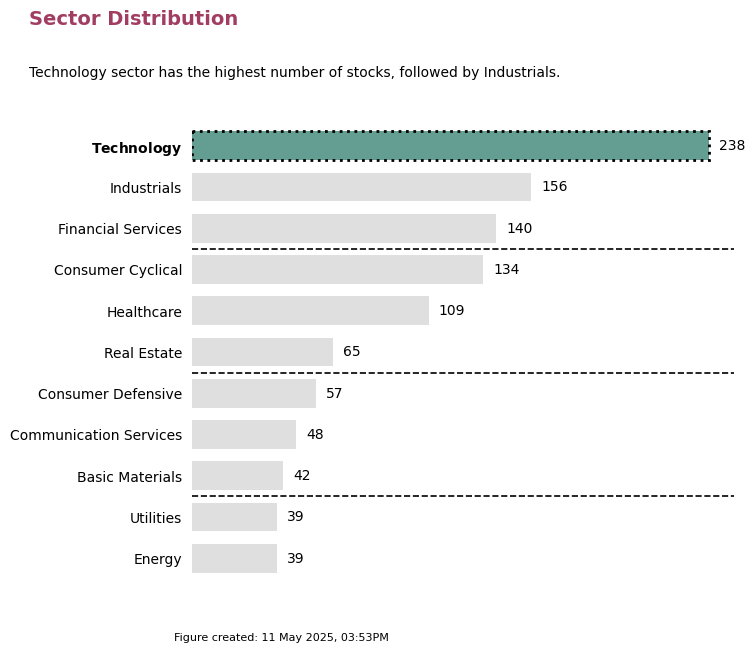

In [5]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique industry counts
temp_df = entire_df[['symbol', 'sector']].drop_duplicates()
sector_counts = temp_df['sector'].value_counts().sort_values(ascending=False)

# Identify the industry with the highest count
max_index = sector_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if sector != max_index else pred_color_presentation('color4') for sector in sector_counts.index]

# Create a horizontal bar chart with highest at the top
ax = sector_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(sector_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for sector in sector_counts.index:
    if sector == max_index:
        yticklabels.append(f"$\\bf{{{sector}}}$")
    else:
        yticklabels.append(sector)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(sector_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, industry in zip(sector_counts, bar_y_positions, sector_counts.index):
    fontweight = 'bold' if sector == max_index else 'normal'
    ax.text(
        count + max(sector_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, sector in zip(bar_containers[0], sector_counts.index):
    if sector == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Sector Distribution', 
    xy=(-0.3, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{sector_counts.index[0]} sector has the highest number of stocks, followed by {sector_counts.index[1]}.', 
    xy=(-0.3, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    0.1,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'sector_distribution.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

### Technology

In [6]:
sector = 'Technology'

query = f"""
SELECT a.symbol, a.timestamp, a.close, y.longname, y.sector, y.industry
FROM yahoo_finance_info_new y, yahoo_data_hour a
WHERE y.symbol = a.symbol
AND y.sector = '{sector}';
"""

original_df = db.fetch_data(query)
print(f"The number of stocks selected for analysis are {len(original_df['symbol'].unique())}")

# format sector after running query to use in code
sector = sector.lower().replace(' ', '_')

The number of stocks selected for analysis are 238


In [7]:
original_df.to_pickle('original_df.pkl')

In [8]:
original_df.head(5)

,symbol,timestamp,close,longname,sector,industry
0,AAPL,2024-04-01 08:30:00-05:00,170.0899,Apple Inc.,Technology,Consumer Electronics
1,AAPL,2024-04-01 09:30:00-05:00,169.8450,Apple Inc.,Technology,Consumer Electronics
2,AAPL,2024-04-01 10:30:00-05:00,169.8950,Apple Inc.,Technology,Consumer Electronics
3,AAPL,2024-04-01 11:30:00-05:00,169.9157,Apple Inc.,Technology,Consumer Electronics
4,AAPL,2024-04-01 12:30:00-05:00,169.9950,Apple Inc.,Technology,Consumer Electronics


## Gaps

In [9]:
symbol_counts = pd.DataFrame(original_df['symbol'].value_counts())
high = symbol_counts['count'].head(1).values
low = symbol_counts['count'].tail(1).values
if high[0] == low[0]:
    print('The values match, no need to perform any cleaning activity.')
else:
    print('The values do not match')

The values do not match


In [10]:
# Calculate 70% of the highest count
high_percent = high[0] * 0.80

# Filter symbols
filtered_symbols = symbol_counts[symbol_counts['count']> 1800]

# Get the symbols from filtered_symbols
filtered_symbol_list = filtered_symbols.index
# Filter result_df based on the selected symbols
original_df = original_df[original_df['symbol'].isin(filtered_symbol_list)]

In [11]:
print(f"The number of stocks selected for analysis are {len(original_df['symbol'].unique())}")

The number of stocks selected for analysis are 234


In [12]:
# 1. Get the highest count
highest_count = original_df['timestamp'].value_counts().max()

# 2. Get the timestamps that have this highest count (handles ties)
most_common_timestamps = original_df['timestamp'].value_counts()[original_df['timestamp'].value_counts() == highest_count].index.tolist()

# 3. Filter the DataFrame
original_df = original_df[original_df['timestamp'].isin(most_common_timestamps)]

print(f"The number of unique stocks remaining are {len(original_df['symbol'].unique())}")

The number of unique stocks remaining are 234


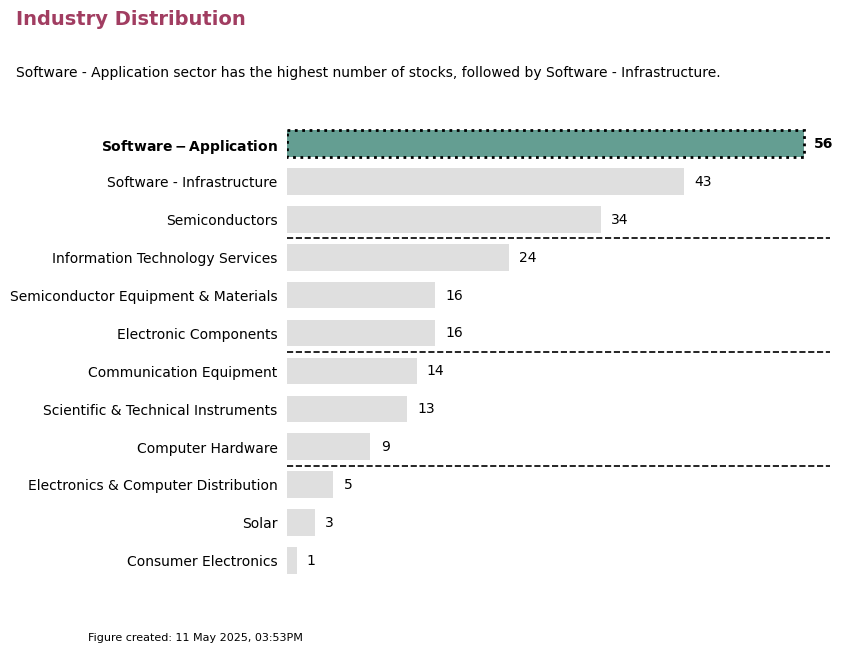

In [13]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique industry counts
temp_df = original_df[['symbol', 'industry']].drop_duplicates()
industry_counts = temp_df['industry'].value_counts().sort_values(ascending=False)

# Identify the industry with the highest count
max_index = industry_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if industry != max_index else pred_color_presentation('color4') for industry in industry_counts.index]

# Create a horizontal bar chart with highest at the top
ax = industry_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(industry_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for industry in industry_counts.index:
    if industry == max_index:
        yticklabels.append(f"$\\bf{{{industry}}}$")
    else:
        yticklabels.append(industry)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(industry_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, industry in zip(industry_counts, bar_y_positions, industry_counts.index):
    fontweight = 'bold' if industry == max_index else 'normal'
    ax.text(
        count + max(industry_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, industry in zip(bar_containers[0], industry_counts.index):
    if industry == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Industry Distribution', 
    xy=(-0.5, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{industry_counts.index[0]} sector has the highest number of stocks, followed by {industry_counts.index[1]}.', 
    xy=(-0.5, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    -0.16,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'industry_distribution_{sector}.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

# Traditional Method

## Feature Engineering

### Additional Columns

In [14]:
traditional_result_df = original_df.copy()

data_clustering = traditional_result_df.pivot(index='timestamp', columns='symbol', values = 'close')

In [15]:
#Calculate returns and create a data frame
returns = data_clustering.pct_change().mean()*266
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = data_clustering.pct_change().std()*np.sqrt(266)

data_clustering = returns
data_clustering.head()

,returns,volatility
symbol,,
AAPL,0.029398,0.117109
ACIW,0.076715,0.133894
ACLS,-0.108584,0.198860
ACN,-0.021956,0.103044
ADBE,-0.042195,0.143547


### Scaling Data

In [16]:
# Scaling the data


#Prepare the scaler
scale = StandardScaler().fit(data_clustering)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data_clustering),
                           columns = data_clustering.columns, 
                           index = data_clustering.index)
X = scaled_data
X.head(5)

,returns,volatility
symbol,,
AAPL,0.680925,-0.947901
ACIW,1.462992,-0.678066
ACLS,-1.599666,0.366298
ACN,-0.167862,-1.174008
ADBE,-0.502374,-0.522885


### Outlier detection

In [17]:
def outlier_lower_iqr(col_name, th1=0.05, th3=0.95):
    quartile1 = X[col_name].quantile(th1)
    quartile3 = X[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit
def outlier_upper_iqr(col_name, th1=0.05, th3=0.95):
    quartile1 = X[col_name].quantile(th1)
    quartile3 = X[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    return upper_limit

In [18]:
# Removing outlier prices based on IQR - InterQuartile Range
num_list=[ "returns", "volatility"]

for i in num_list:
    X=X[X[i].between(outlier_lower_iqr(i), outlier_upper_iqr(i))]

## KMeans

### Elbow Detection

In [19]:
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

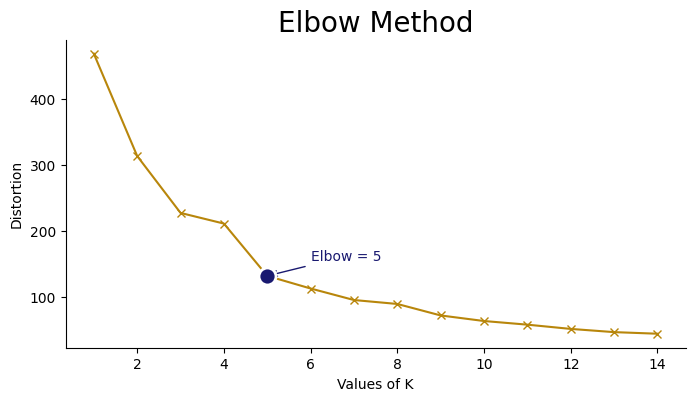

In [20]:
# Find the elbow
kl = KneeLocator(range(1, 15), distortions, curve="convex", direction="decreasing")
elbow_x = kl.elbow
elbow_y = distortions[elbow_x - 1]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Line plot
plt.plot(K, distortions, marker='x', color=pred_color_presentation('muted-gold'), label='Distortion')

# Mark elbow with a circle
plt.scatter(
    elbow_x, elbow_y,
    s=150,  # size of the circle
    color=pred_color_presentation('midnight-blue'),
    edgecolors='white',
    linewidth=2,
    zorder=5,
    label=f'Elbow = {elbow_x}'
)

# Annotate elbow point
plt.annotate(
    f'Elbow = {elbow_x}',
    xy=(elbow_x, elbow_y),
    xytext=(elbow_x + 1, elbow_y + max(distortions) * 0.05),
    fontsize=10,
    color=pred_color_presentation('midnight-blue'),
    arrowprops=dict(arrowstyle='->', color=pred_color_presentation('midnight-blue')),
    ha='left'
)

# Axis labels and title
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method', fontsize=20)

plt.grid(False)

# Save
fig_name = f'elbow_method_{sector}.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

In [21]:
# Run KMeans from scratch
elbow_x = 7
k_means = KMeans(n_clusters=elbow_x, random_state=42)  # Replace 3 with your desired number of clusters
k_means.fit(X)
prediction = k_means.predict(X)

### Cluster Visualization

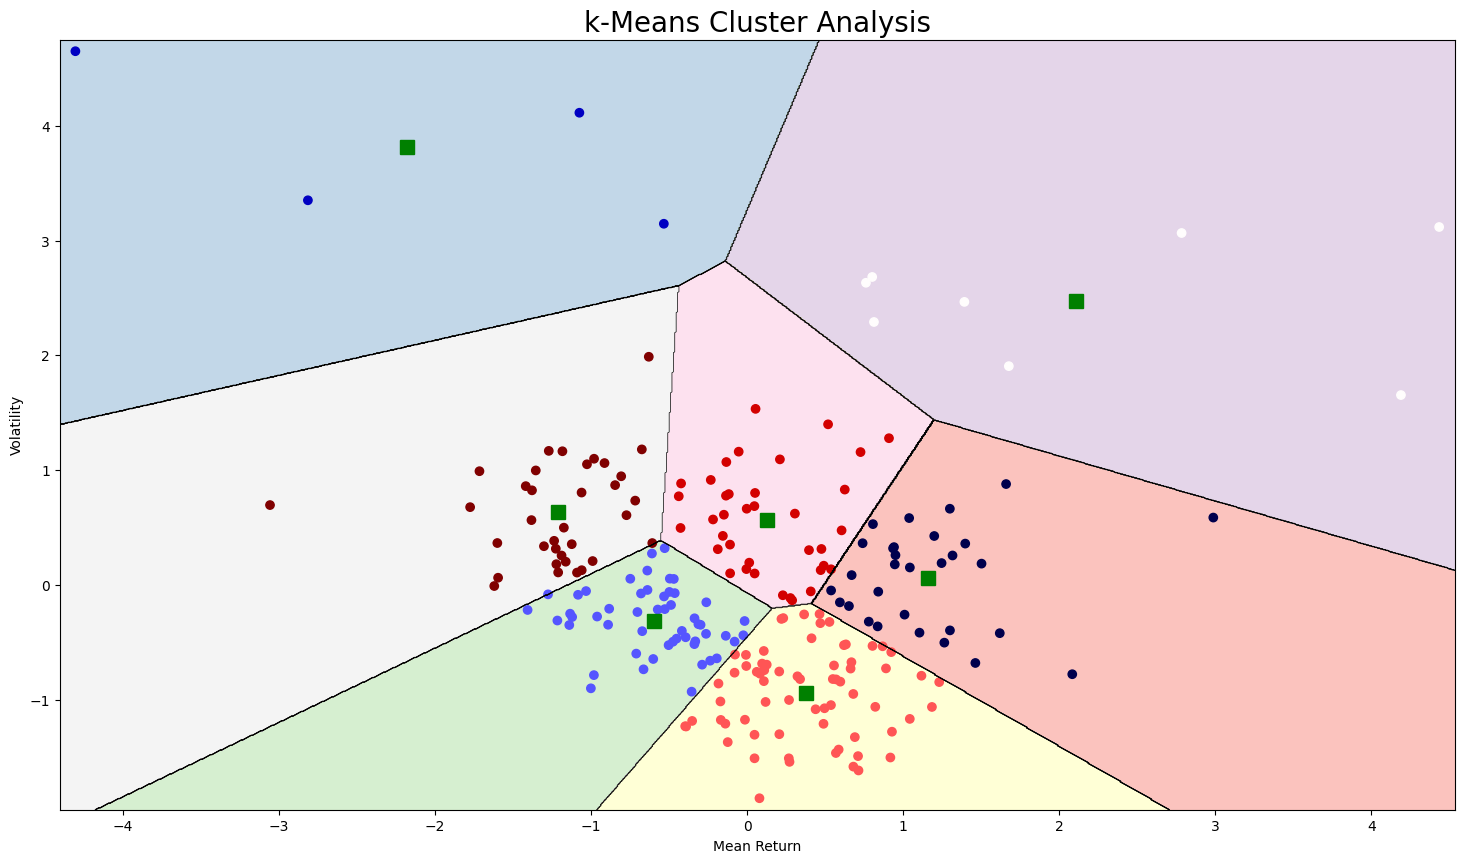

In [22]:
# Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)

# Define the grid for plotting
resolution = 1000  # Adjust resolution for smoother contours
mins = X.min(axis=0) - 0.1
maxs = X.max(axis=0) + 0.1
xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))

# Predict clusters for the grid points
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_df = pd.DataFrame(grid_points, columns=X.columns)  # Add feature names to match training data
Z = k_means.predict(grid_points_df)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel1", alpha=0.8)
plt.contour(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=0.5, colors='k')

# Plot the data points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_, cmap="seismic", label=X.index)

# Plot the centroids
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=10, label='Centroids')

# Add labels and title
ax.set_title('k-Means Cluster Analysis', fontsize=20)
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')

# Save and show the plot
fig_name = f'kmeans_{sector}.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

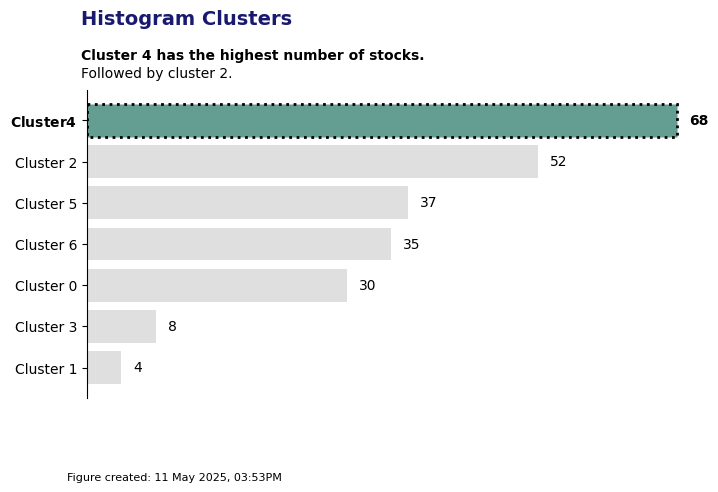

In [23]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]  # Remove noise if any

# Sort the counts in descending order
counts = clustered_series.value_counts().sort_values(ascending=False)
max_cluster = counts.index[0]  # Cluster with the highest count

# Define colors
main_color = pred_color_presentation('color4')  # Muted gold
other_color = pred_color_presentation('color1')  # Light gray
highlight_color = pred_color_presentation('black')  # Border color

# Assign bar colors
colors = [main_color if i == 0 else other_color for i in range(len(counts))]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
bars = plt.barh(range(len(counts)), counts, color=colors, edgecolor='none')
ax.invert_yaxis()

# Add special borders
for i, (bar, count) in enumerate(zip(bars, counts)):
    if counts.index[i] == max_cluster:
        bar.set_edgecolor(pred_color_presentation('black'))
        bar.set_linewidth(2)
        bar.set_linestyle('dotted')
    elif count == 1:
        bar.set_edgecolor(highlight_color)
        bar.set_linewidth(2)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)

# Set x-ticks and y-ticks
ax.set_xticks([])
ax.set_yticks(range(len(counts)))

# ✅ Format y-tick labels as "Cluster X" and bold the one with the max
yticklabels = []
for cluster in counts.index:
    label = f"Cluster {cluster}"
    if cluster == max_cluster:
        yticklabels.append(f"$\\bf{{{label}}}$")
    else:
        yticklabels.append(label)
ax.set_yticklabels(yticklabels, fontsize=10)

# Add count labels beside bars
bar_y_positions = [bar.get_y() + bar.get_height() / 2 for bar in bars]
for count, y_pos, cluster in zip(counts, bar_y_positions, counts.index):
    fontweight = 'bold' if cluster == max_cluster else 'normal'
    ax.text(
        count + max(counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Title and annotation
plt.annotate(
    'Histogram Clusters', 
    xy=(-0.01, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('midnight-blue')
)

plt.annotate(
    f'Cluster {counts.index[0]} has the highest number of stocks.', 
    xy=(-0.01, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color='black'
)

plt.annotate(
    f'Followed by cluster {counts.index[1]}.', 
    xy=(-0.01, 1.03), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)



# Add footnote
plt.figtext(
    0.1,  
    -0.1,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Optional warning for cluster with 1 stock
if any(counts == 1):
    plt.figtext(
        0.1,  
        -0.05,  
        f"One of the clusters has only 1 record and will be removed",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=8,
        color='black'
    )


# Save and show the plot
fig_name = f'kmeans_histogram_{sector}.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

## Log Close Price

### One Cluster

In [24]:
counts_desc = clustered_series.value_counts().sort_values(ascending=True)
selected_cluster = counts_desc.index[0]
selected_cluster = 0
selected_cluster

0

In [25]:
# convert series into a dataframe
clustered_series_df = clustered_series.to_frame(name='cluster')
clustered_series_df = clustered_series_df.reset_index()
list_symbols = clustered_series_df['symbol'][clustered_series_df['cluster']==selected_cluster].values.tolist()

In [26]:
ta_df = traditional_result_df[['symbol', 'timestamp', 'close']][traditional_result_df['symbol'].isin(list_symbols)]

# Step 1: Sort the DataFrame by 'symbol' and 'timestamp'
ta_df = ta_df.sort_values(by=['symbol', 'timestamp'])

# Step 2: Create the log_close column by applying log transformation within the group
ta_df['log_close'] = ta_df.groupby('symbol')['close'].transform(lambda x: np.log(x))

# Display the first 5 rows
ta_df.head(5)

,symbol,timestamp,close,log_close
1941,ACIW,2024-04-01 08:30:00-05:00,32.800,3.490429
1942,ACIW,2024-04-01 09:30:00-05:00,32.500,3.481240
1943,ACIW,2024-04-01 10:30:00-05:00,32.230,3.472898
1944,ACIW,2024-04-01 11:30:00-05:00,32.215,3.472432
1945,ACIW,2024-04-01 12:30:00-05:00,32.180,3.471345


In [27]:
ta_df_pivot_df = ta_df.pivot(index='timestamp', columns='symbol', values = 'log_close')

In [28]:
# Generate unique pairs of symbols
symbols = ta_df_pivot_df.columns
symbol_pairs = list(itertools.combinations(symbols, 2))
print(f"There are {len(symbol_pairs)} unique pairs in cluster {max_cluster}")

There are 435 unique pairs in cluster 4


#### Correlation

In [29]:
# Initialize an empty list to store the correlation values
correlations = []

# Loop through the symbol pairs and compute the correlation for each pair
for pair in symbol_pairs:
    symbol_1, symbol_2 = pair
    corr_value = ta_df_pivot_df[symbol_1].corr(ta_df_pivot_df[symbol_2])
    correlations.append([symbol_1, symbol_2, corr_value])

limit = 0.9

# Convert the correlations list into a DataFrame
correlation_df = pd.DataFrame(correlations, columns=['Symbol_1', 'Symbol_2', 'Correlation'])
correlation_df_filtered = correlation_df[correlation_df['Correlation'] > limit].sort_values(by='Correlation', ascending=False)
print(f"There are {len(correlation_df_filtered)} pairs above {limit}")

There are 37 pairs above 0.9


In [30]:
correlation_df_filtered.head(5)

,Symbol_1,Symbol_2,Correlation
6,ACIW,CVLT,0.963171
220,DOCU,TWLO,0.960093
279,FTNT,VIAV,0.949325
326,IDCC,UI,0.949314
139,CIEN,FOUR,0.943214


In [31]:
# Convert filtered DataFrame into a list of highlighted pairs
highlight_pairs = list(correlation_df_filtered[[  'Symbol_2', 'Symbol_1']].itertuples(index=False, name=None))

# Display the top 10 pairs
highlight_pairs = highlight_pairs[:10]

In [32]:
# Get all unique symbols
all_symbols = sorted(list(set(correlation_df_filtered['Symbol_1']).union(set(correlation_df_filtered['Symbol_2']))))

# Build symmetric matrix
corr_matrix = pd.DataFrame(0, index=all_symbols, columns=all_symbols)
for _, row in correlation_df_filtered.iterrows():
    sym1, sym2, corr = row['Symbol_1'], row['Symbol_2'], row['Correlation']
    corr_matrix.loc[sym1, sym2] = corr
    corr_matrix.loc[sym2, sym1] = corr  # Mirror the value

# Set diagonal to 1 (optional)
np.fill_diagonal(corr_matrix.values, 1)

# Use this instead of corr_pivot
corr_pivot = corr_matrix

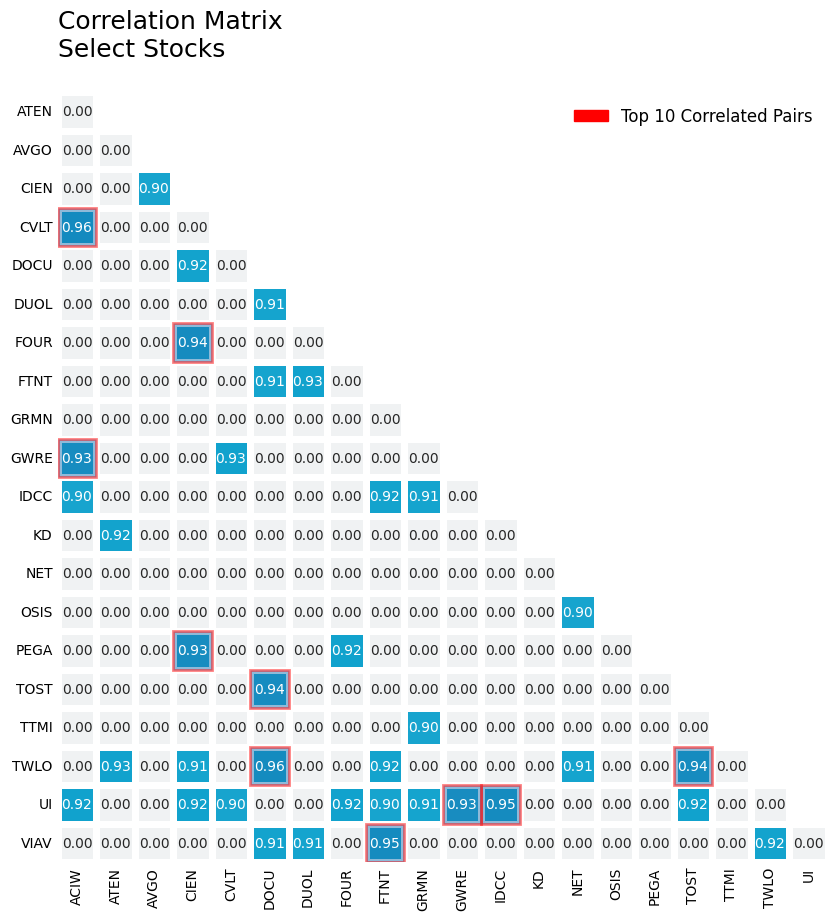

In [34]:
# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_pivot, dtype=bool))
mask = mask[1:, :-1]

# Adjusted correlation matrix for plotting
corr = corr_pivot.iloc[1:, :-1].copy()

# Color map
cmap = sns.diverging_palette(0, 230, 100, 60, as_cmap=True)
# cmap = sns.diverging_palette(240, 60, s=90, l=50, as_cmap=True)

# Plot heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    linewidths=5,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    square=True,
    cbar=False  # Remove color bar
)

# Remove x and y axis labels
#ax.set_xlabel('')
#ax.set_ylabel('')

# Remove tick marks but keep tick labels
ax.tick_params(axis='both', length=0)

# Set custom tick labels
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# Highlight specific pairs by changing the background color of the heatmap square
for sym1, sym2 in highlight_pairs:
    if sym1 in corr.index and sym2 in corr.columns:
        # Get coordinates of the pair
        x = corr.columns.get_loc(sym2)
        y = corr.index.get_loc(sym1)
        
        # Highlight the square by changing its color (using facecolor and edgecolor separately)
        ax.add_patch(plt.Rectangle(
            (x, y), 1, 1,  alpha=0.5, lw=2, edgecolor='red'))

        # Annotate the value in the highlighted square
        #val = corr.loc[sym1, sym2]
        #ax.text(x + 0.5, y + 0.5, f"{val:.2f}",
                #ha='center', va='center', fontsize=12,
                #fontweight='bold', color='black')
# Create a legend with a red box representing the top pairs
red_patch = patches.Patch(color='red', label=f'Top {len(highlight_pairs)} Correlated Pairs')

# Add the legend to the plot
plt.legend(handles=[red_patch], loc='upper right', fontsize=12, frameon=False)

# Title
plt.title('Correlation Matrix\nSelect Stocks\n', loc='left', fontsize=18)

fig_name = f'correlation_matrix_{sector}.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

In [35]:
final_results_df = correlation_df_filtered.copy()
final_results_df.head(5)

,Symbol_1,Symbol_2,Correlation
6,ACIW,CVLT,0.963171
220,DOCU,TWLO,0.960093
279,FTNT,VIAV,0.949325
326,IDCC,UI,0.949314
139,CIEN,FOUR,0.943214


#### Cointegration

In [36]:
def calculate_beta_from_long_df(ta_df, symbol1, symbol2):
    """
    Calculates hedge ratio (beta) for symbol1 ~ symbol2 using log_close prices
    from a long-form DataFrame (columns: symbol, log_close, datetime).
    
    Parameters:
    - ta_df: long-form DataFrame with at least 'symbol', 'log_close', and a datetime index or column
    - symbol1: str, dependent variable
    - symbol2: str, independent variable
    
    Returns:
    - beta: float, hedge ratio
    """
    # Filter log_close series for both symbols
    price_1 = ta_df[ta_df['symbol'] == symbol1][['timestamp', 'log_close']].set_index('timestamp')
    price_2 = ta_df[ta_df['symbol'] == symbol2][['timestamp', 'log_close']].set_index('timestamp')
    
    # Rename columns for merging
    price_1 = price_1.rename(columns={'log_close': symbol1})
    price_2 = price_2.rename(columns={'log_close': symbol2})
    
    # Merge and drop missing
    combined = price_1.join(price_2, how='inner').dropna()

    # OLS regression: symbol1 ~ symbol2
    X = sm.add_constant(combined[symbol2])
    y = combined[symbol1]
    
    model = sm.OLS(y, X).fit()
    beta = model.params[symbol2]

    #print(f"Beta (hedge ratio) for {symbol1} ~ {symbol2}: {beta:.4f}")
    return beta

In [37]:
# Ensure the column exists
final_results_df['beta'] = None

# Loop through each row in final_results_df with tqdm progress bar
for idx, row in tqdm(final_results_df.iterrows(), total=len(final_results_df), 
                     desc='Calculating Beta', unit='rows'):
    symbol1 = row['Symbol_1']
    symbol2 = row['Symbol_2']
    
    try:
        beta = calculate_beta_from_long_df(ta_df, symbol1, symbol2)
        final_results_df.at[idx, 'beta'] = beta
    except Exception as e:
        print(f"Error calculating beta for {symbol1} ~ {symbol2}: {e}")
        final_results_df.at[idx, 'beta'] = None

Calculating Beta:   0%|          | 0/37 [00:00<?, ?rows/s]

#### ADF Test

In [38]:
def get_adf_results_from_residuals(ta_df, symbol1, symbol2):
    # Extract log_close series
    price_1 = ta_df[ta_df['symbol'] == symbol1][['timestamp', 'log_close']].set_index('timestamp')
    price_2 = ta_df[ta_df['symbol'] == symbol2][['timestamp', 'log_close']].set_index('timestamp')
    
    price_1 = price_1.rename(columns={'log_close': symbol1})
    price_2 = price_2.rename(columns={'log_close': symbol2})
    
    combined = price_1.join(price_2, how='inner').dropna()

    # OLS regression: symbol1 ~ symbol2
    X = sm.add_constant(combined[symbol2])
    y = combined[symbol1]
    
    model = sm.OLS(y, X).fit()
    residuals = model.resid

    # Run ADF test on residuals
    adf_result = adfuller(residuals)
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]

    return adf_stat, adf_pvalue

In [39]:
final_results_df['adf_stat'] = None
final_results_df['adf_pvalue'] = None

for idx, row in final_results_df.iterrows():
    symbol1 = row['Symbol_1']
    symbol2 = row['Symbol_2']
    
    try:
        adf_stat, adf_pvalue = get_adf_results_from_residuals(ta_df, symbol1, symbol2)
        final_results_df.at[idx, 'adf_stat'] = adf_stat
        final_results_df.at[idx, 'adf_pvalue'] = adf_pvalue
    except Exception as e:
        print(f"Error running ADF for {symbol1} ~ {symbol2}: {e}")
        final_results_df.at[idx, 'adf_stat'] = None
        final_results_df.at[idx, 'adf_pvalue'] = None


In [40]:
cointegrated_pairs_df = final_results_df[final_results_df['adf_pvalue'] < 0.05].copy()
cointegrated_pairs_df = cointegrated_pairs_df.sort_values(by='adf_pvalue', ascending=False)
cointegrated_pairs_df.head(5)

,Symbol_1,Symbol_2,Correlation,beta,adf_stat,adf_pvalue
137,CIEN,DOCU,0.918167,0.970252,-2.874171,0.048435
416,TOST,UI,0.924826,0.461994,-2.87464,0.048378
12,ACIW,GWRE,0.933947,0.830726,-2.93679,0.041234
352,NET,TWLO,0.913337,0.660623,-2.943885,0.040478
85,AVGO,CIEN,0.901877,0.716989,-3.009541,0.034013


#### Rolling Beta

Optimize Spread Parameters:

Recalculate the hedge ratio (β) over rolling windows to ensure stability.

In [41]:
def calculate_hurst_for_pairs(ta_df, cointegrated_pairs_df, window=7):
    """
    Calculate Hurst exponent for all pairs in cointegrated_pairs_df and add results as new column
    
    Parameters:
    - ta_df: DataFrame containing timestamp, symbol, and log_close prices
    - cointegrated_pairs_df: DataFrame with columns Symbol_1, Symbol_2, etc.
    - window: Rolling window size for beta calculation
    
    Returns:
    - DataFrame with added 'hurst_exponent' column
    """
    
    hurst_values = []
    
    for _, row in tqdm(cointegrated_pairs_df.iterrows(), total=len(cointegrated_pairs_df), 
                       desc='Calculating Hurst Value',
                       unit='rows'):
        symbol1 = row['Symbol_1']
        symbol2 = row['Symbol_2']
        
        try:
            # Prepare the price series
            p1 = ta_df[ta_df['symbol'] == symbol1][['timestamp', 'log_close']].set_index('timestamp')
            p2 = ta_df[ta_df['symbol'] == symbol2][['timestamp', 'log_close']].set_index('timestamp')
            
            p1 = p1.rename(columns={'log_close': symbol1})
            p2 = p2.rename(columns={'log_close': symbol2})
            
            combined = p1.join(p2, how='inner').dropna()

            # Skip if not enough data points
            if len(combined) < window + 1:
                hurst_values.append(None)
                continue

            # Calculate rolling betas
            betas = []
            for i in range(window, len(combined)):
                window_df = combined.iloc[i-window:i]
                X = sm.add_constant(window_df[symbol2])
                y = window_df[symbol1]
                model = sm.OLS(y, X).fit()
                beta = model.params[symbol2]
                betas.append((combined.index[i], beta))

            # Convert to DataFrame
            beta_df = pd.DataFrame(betas, columns=['timestamp', 'rolling_beta']).set_index('timestamp')

            # Calculate Hurst exponent
            data = beta_df['rolling_beta'].values
            H, c, data = hurst.compute_Hc(data)
            hurst_values.append(H)
            
        except Exception as e:
            print(f"Error processing pair {symbol1}-{symbol2}: {str(e)}")
            hurst_values.append(None)
    
    # Add results to original dataframe
    cointegrated_pairs_df['hurst_exponent'] = hurst_values
    return cointegrated_pairs_df

In [42]:
import hurst
cointegrated_pairs_df = calculate_hurst_for_pairs(ta_df, cointegrated_pairs_df, window=7)

Calculating Hurst Value:   0%|          | 0/24 [00:00<?, ?rows/s]

In [43]:
def filter_good_pairs(pairs_df, 
                     max_pvalue=0.05, 
                     max_hurst=0.5, 
                     min_correlation=0.8,
                     min_beta_stability=None):
    """
    Filter pairs based on cointegration and mean-reversion criteria
    
    Parameters:
    - pairs_df: DataFrame with pair statistics
    - max_pvalue: Maximum ADF p-value threshold (default 0.05)
    - max_hurst: Maximum Hurst exponent threshold (default 0.5)
    - min_correlation: Minimum correlation threshold (default 0.7)
    - min_beta_stability: Optional minimum beta stability (None to disable)
    
    Returns:
    - Filtered DataFrame of good pairs
    """
    
    # Apply filters
    good_pairs = pairs_df[
        (pairs_df['adf_pvalue'] < max_pvalue) &
        (pairs_df['hurst_exponent'] < max_hurst) &
        (pairs_df['Correlation'] > min_correlation)
    ].copy()
    
    # Optional beta stability filter
    if min_beta_stability is not None and 'beta_stability' in pairs_df.columns:
        good_pairs = good_pairs[good_pairs['beta_stability'] > min_beta_stability]
    
    # Sort by most promising pairs first
    good_pairs = good_pairs.sort_values(
        by=['adf_pvalue', 'hurst_exponent'], 
        ascending=[True, True]
    )
    
    # Add a composite score if you want to rank pairs
    good_pairs['pair_score'] = (
        (1 - good_pairs['adf_pvalue']) + 
        (1 - good_pairs['hurst_exponent']) +
        good_pairs['Correlation']
    )
    
    return good_pairs

In [44]:
# Filter with default parameters
pairs_traditional = filter_good_pairs(cointegrated_pairs_df)

print(f"Identified {len(pairs_traditional)} potential pairs for pairs trading in cluster {selected_cluster}")

Identified 24 potential pairs for pairs trading in cluster 0


In [46]:
pairs_traditional.head(5).reset_index(drop=True)

,Symbol_1,Symbol_2,Correlation,beta,adf_stat,adf_pvalue,hurst_exponent,pair_score
0,ACIW,CVLT,0.963171,0.947161,-4.322008,0.000407,0.283580,2.679184
1,FTNT,VIAV,0.949325,1.240485,-4.109969,0.000932,0.418895,2.529497
2,CIEN,FOUR,0.943214,1.050217,-3.788212,0.00303,0.354016,2.586168
3,DOCU,TWLO,0.960093,0.663307,-3.775068,0.003173,0.375373,2.581547
4,DUOL,VIAV,0.910391,1.473681,-3.734122,0.003658,0.360904,2.545829


In [49]:
print(pairs_traditional.head(5).reset_index(drop=True).to_markdown(index=False))

| Symbol_1   | Symbol_2   |   Correlation |     beta |   adf_stat |   adf_pvalue |   hurst_exponent |   pair_score |
|:-----------|:-----------|--------------:|---------:|-----------:|-------------:|-----------------:|-------------:|
| ACIW       | CVLT       |      0.963171 | 0.947161 |   -4.32201 |  0.000406805 |         0.28358  |      2.67918 |
| FTNT       | VIAV       |      0.949325 | 1.24049  |   -4.10997 |  0.000932422 |         0.418895 |      2.5295  |
| CIEN       | FOUR       |      0.943214 | 1.05022  |   -3.78821 |  0.00303025  |         0.354016 |      2.58617 |
| DOCU       | TWLO       |      0.960093 | 0.663307 |   -3.77507 |  0.00317296  |         0.375373 |      2.58155 |
| DUOL       | VIAV       |      0.910391 | 1.47368  |   -3.73412 |  0.00365801  |         0.360904 |      2.54583 |


### All Clusters

#### Correlation

In [50]:
counts_desc = clustered_series.value_counts().sort_values(ascending=True)
# min_cluster = counts_desc.index[0]
#min_cluster = 4

In [51]:
# convert series into a dataframe
clustered_series_df = clustered_series.to_frame(name='cluster')
clustered_series_df = clustered_series_df.reset_index()

In [52]:
symbol_pairs = [
    pair for _, group in clustered_series_df.groupby('cluster')
    for pair in itertools.combinations(group['symbol'], 2)
]
print(f"There are {len(symbol_pairs)} unique pairs")

There are 5334 unique pairs


In [53]:
ta_df = traditional_result_df[['symbol', 'timestamp', 'close']]

# Step 1: Sort the DataFrame by 'symbol' and 'timestamp'
ta_df = ta_df.sort_values(by=['symbol', 'timestamp'])

# Step 2: Create the log_close column by applying log transformation within the group
ta_df['log_close'] = ta_df.groupby('symbol')['close'].transform(lambda x: np.log(x))

# Display the first 5 rows
ta_df.head(5)

,symbol,timestamp,close,log_close
0,AAPL,2024-04-01 08:30:00-05:00,170.0899,5.136327
1,AAPL,2024-04-01 09:30:00-05:00,169.8450,5.134886
2,AAPL,2024-04-01 10:30:00-05:00,169.8950,5.135181
3,AAPL,2024-04-01 11:30:00-05:00,169.9157,5.135302
4,AAPL,2024-04-01 12:30:00-05:00,169.9950,5.135769


In [54]:
ta_df_pivot_df = ta_df.pivot(index='timestamp', columns='symbol', values = 'log_close')

In [55]:
# Initialize an empty list to store the correlation values
correlations = []

# Loop through the symbol pairs and compute the correlation for each pair
for pair in symbol_pairs:
    symbol_1, symbol_2 = pair
    corr_value = ta_df_pivot_df[symbol_1].corr(ta_df_pivot_df[symbol_2])
    correlations.append([symbol_1, symbol_2, corr_value])

limit = 0.8

# Convert the correlations list into a DataFrame
correlation_df = pd.DataFrame(correlations, columns=['Symbol_1', 'Symbol_2', 'Correlation'])
correlation_df_filtered = correlation_df[correlation_df['Correlation'] > limit].sort_values(by='Correlation', ascending=False)
print(f"There are {len(correlation_df_filtered)} pairs above {limit}")

There are 792 pairs above 0.8


In [56]:
final_results_df = correlation_df_filtered.copy()
final_results_df.head(5)

,Symbol_1,Symbol_2,Correlation
2039,ADP,PAYX,0.977512
2016,ADP,FI,0.975206
2951,CSCO,FI,0.971970
1786,APP,PLTR,0.969883
4740,ACLS,AMKR,0.968522


#### Cointegration

In [57]:
# Ensure the column exists
final_results_df['beta'] = None

# Loop through each row in final_results_df with tqdm progress bar
for idx, row in tqdm(final_results_df.iterrows(), total=len(final_results_df), 
                     desc = 'Calculating cointegration',
                     unit='rows'):
    symbol1 = row['Symbol_1']
    symbol2 = row['Symbol_2']
    
    try:
        beta = calculate_beta_from_long_df(ta_df, symbol1, symbol2)
        final_results_df.at[idx, 'beta'] = beta
    except Exception as e:
        print(f"Error calculating beta for {symbol1} ~ {symbol2}: {e}")
        final_results_df.at[idx, 'beta'] = None

Calculating cointegration:   0%|          | 0/792 [00:00<?, ?rows/s]

#### ADF Test

In [58]:
final_results_df['adf_stat'] = None
final_results_df['adf_pvalue'] = None

for idx, row in tqdm(final_results_df.iterrows(), total=len(final_results_df), 
                     desc = 'Calculating ADF Value',
                     unit='rows'):
    symbol1 = row['Symbol_1']
    symbol2 = row['Symbol_2']
    
    try:
        adf_stat, adf_pvalue = get_adf_results_from_residuals(ta_df, symbol1, symbol2)
        final_results_df.at[idx, 'adf_stat'] = adf_stat
        final_results_df.at[idx, 'adf_pvalue'] = adf_pvalue
    except Exception as e:
        print(f"Error running ADF for {symbol1} ~ {symbol2}: {e}")
        final_results_df.at[idx, 'adf_stat'] = None
        final_results_df.at[idx, 'adf_pvalue'] = None

Calculating ADF Value:   0%|          | 0/792 [00:00<?, ?rows/s]

In [59]:
cointegrated_pairs_df = final_results_df[final_results_df['adf_pvalue'] < 0.05].copy()
cointegrated_pairs_df = cointegrated_pairs_df.sort_values(by='adf_pvalue', ascending=False)
cointegrated_pairs_df.head(5)

,Symbol_1,Symbol_2,Correlation,beta,adf_stat,adf_pvalue
5021,ENTG,MU,0.884547,0.855573,-2.864099,0.049685
3936,PAYX,ZM,0.860522,0.515246,-2.864612,0.049621
1454,NXPI,SNPS,0.821610,0.958696,-2.866129,0.049431
3742,KEYS,TRMB,0.862729,0.641926,-2.867143,0.049304
572,AMAT,QCOM,0.886471,1.203961,-2.867462,0.049265


#### Rolling Beta

In [60]:
import hurst
cointegrated_pairs_df = calculate_hurst_for_pairs(ta_df, cointegrated_pairs_df, window=7)

Calculating Hurst Value:   0%|          | 0/316 [00:00<?, ?rows/s]

In [61]:
# Filter with default parameters
pairs_traditional = filter_good_pairs(cointegrated_pairs_df)

print(f"Identified {len(pairs_traditional)} potential pairs for pairs trading" )

Identified 316 potential pairs for pairs trading


In [62]:
pairs_traditional.head(5)

,Symbol_1,Symbol_2,Correlation,beta,adf_stat,adf_pvalue,hurst_exponent,pair_score
1499,PDFS,ROG,0.965468,0.994523,-5.135042,0.000012,0.325772,2.639685
3929,PAYX,TDY,0.951454,0.836669,-5.027547,0.00002,0.304369,2.647066
3275,FI,PAYX,0.967828,1.83073,-4.974192,0.000025,0.371652,2.596152
3285,FI,TDY,0.967943,1.610059,-4.873544,0.000039,0.367607,2.600297
3882,NTCT,ZM,0.873091,0.474817,-4.723673,0.000076,0.402394,2.470622


In [63]:
print(pairs_traditional.head(5).reset_index(drop=True).to_markdown(index=False))

| Symbol_1   | Symbol_2   |   Correlation |     beta |   adf_stat |   adf_pvalue |   hurst_exponent |   pair_score |
|:-----------|:-----------|--------------:|---------:|-----------:|-------------:|-----------------:|-------------:|
| PDFS       | ROG        |      0.965468 | 0.994523 |   -5.13504 |  1.19142e-05 |         0.325772 |      2.63968 |
| PAYX       | TDY        |      0.951454 | 0.836669 |   -5.02755 |  1.95695e-05 |         0.304369 |      2.64707 |
| FI         | PAYX       |      0.967828 | 1.83073  |   -4.97419 |  2.49568e-05 |         0.371652 |      2.59615 |
| FI         | TDY        |      0.967943 | 1.61006  |   -4.87354 |  3.92542e-05 |         0.367607 |      2.6003  |
| NTCT       | ZM         |      0.873091 | 0.474817 |   -4.72367 |  7.59454e-05 |         0.402394 |      2.47062 |


## Visualization

In [64]:
asset1=pairs_traditional['Symbol_1'].iloc[0]
asset2=pairs_traditional['Symbol_2'].iloc[0]

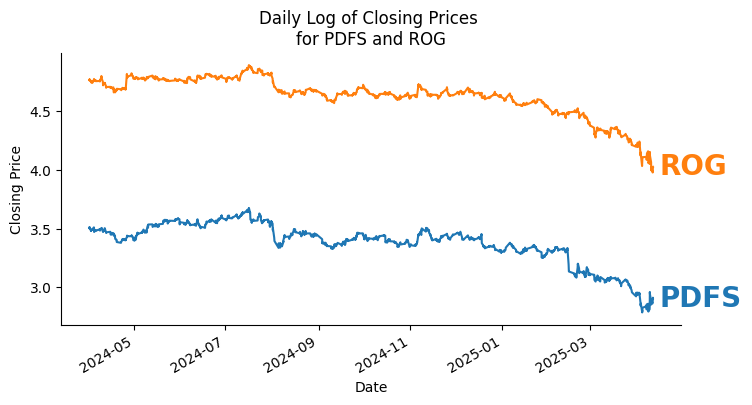

In [65]:
ax = ta_df_pivot_df[[asset1,asset2]].plot(figsize= (8,4), title = 'Daily Log of Closing Prices \nfor {} and {}'.format(asset1,asset2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_ylabel("Closing Price")
ax.set_xlabel("Date")
for line in ax.lines:
        data_x, data_y = line.get_data()
        right_most_x = data_x[-1]
        right_most_y = data_y[-1]
        ax.annotate(
            line.get_label(),
            xy=(right_most_x, right_most_y),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            color=line.get_color(),
            fontsize=20,
            fontweight='bold',
        )
        ax.legend().set_visible(False)
        ax.grid(False);

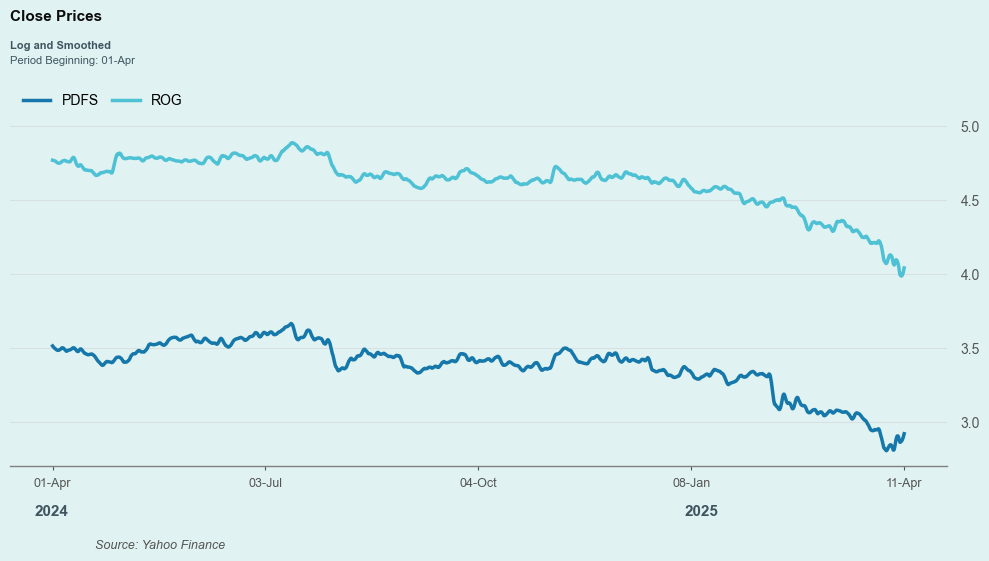

In [68]:
# --- Smoothing Function ---
def smooth_curve(y, window_size=5, order=2):
    return savgol_filter(y, window_size, order)

# --- Set Style Parameters ---
plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Calibri'],
    'grid.color': '#d4d4d4',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'text.color': 'black'
})

# --- Create Figure ---
fig = plt.figure(figsize=(10, 5.5), facecolor='#e0f2f2')
ax = plt.gca()

# --- Plot Smoothed Data ---
y_values = []
for asset, color in zip([asset1, asset2], ['#006BA2', '#3EBCD2']):
    y_smooth = smooth_curve(ta_df_pivot_df[asset].values, 15)
    ax.plot(np.arange(len(y_smooth)), y_smooth, 
            color=color, linewidth=2.5, alpha=0.9, label=asset)
    y_values.extend(y_smooth)

# --- Dynamic Y-Limits ---
y_min, y_max = np.nanmin(y_values), np.nanmax(y_values)
y_range = y_max - y_min
ax.set_ylim([y_min - 0.05*y_range, y_max + 0.20*y_range])

# --- X-Axis Label Formatting ---
n_points = len(y_smooth)
n_labels = 5  # Number of labels desired
step = max(1, n_points // (n_labels - 1))  # Ensure step is at least 1
label_indices = list(range(0, n_points, step))

# If we have too many labels, take first n_labels
if len(label_indices) > n_labels:
    label_indices = label_indices[:n_labels]
# If too few, distribute evenly
elif len(label_indices) < n_labels and n_points > 1:
    label_indices = list(range(0, n_points, max(1, (n_points-1)//(n_labels-1))))

# Improved date formatting that handles 'YYYY-MM-DD HH:MM:SS' format
def format_date(date_str):
    try:
        # Handle both date strings with and without time
        date_part = date_str.split()[0]  # Take only the date part
        parts = date_part.split('-')
        if len(parts) >= 3:
            day = parts[2]
            month_num = int(parts[1])
            month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][month_num-1]
            return f"{day.zfill(2)}-{month_abbr}"  # Ensure two-digit day
    except:
        pass
    return date_str[:10]  # Fallback to first 10 chars if formatting fails

x_labels = [format_date(str(ta_df_pivot_df.index[i])) for i in label_indices]

# Apply custom ticks and labels
ax.xaxis.set_major_locator(FixedLocator(label_indices))
ax.xaxis.set_major_formatter(FixedFormatter(x_labels))

# --- Rest of Styling ---
ax.set_facecolor('#e0f2f2')
plt.annotate('Close Prices', xy=(0, 1.15), xycoords='axes fraction',
             fontsize=11, fontweight='bold', ha='left', va='bottom', color='#0C0C0C')
plt.annotate('Log and Smoothed', xy=(0, 1.08), xycoords='axes fraction',
             fontsize=8, fontweight='bold', ha='left', va='bottom', color='#3F5661')
plt.annotate(f'Period Beginning: {format_date(str(ta_df_pivot_df.index[0]))}', 
             xy=(0, 1.04), xycoords='axes fraction',
             fontsize=8, ha='left', va='bottom', color='#3F5661')

ax.grid(True, axis='y', linestyle='-', alpha=0.6)
ax.grid(False, axis='x')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(axis='y', which='both', length=0, pad=10, labelsize=10)

plt.draw()
for label in ax.get_yticklabels():
    label.set_bbox(dict(facecolor='#e0f2f2', edgecolor='none', pad=2, alpha=0.8))

ax.tick_params(axis='x', which='major', length=3, pad=5, labelsize=9)

if [asset1, asset2]:
    ax.legend(frameon=False, fontsize=10, loc='upper left',
              bbox_to_anchor=(0, 1), ncol=2, handlelength=2, columnspacing=1)

plt.figtext(0.04, 0.06, '2024', ha='left',    fontweight = 'bold',        fontsize=11, color='#3F5661')
plt.figtext(0.69, 0.06, '2025', ha='left',    fontweight = 'bold',        fontsize=11, color='#3F5661')

plt.figtext(0.1, 0.001, 'Source: Yahoo Finance', ha='left',
            fontsize=9, color='#555555', style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.85)

fig_name = f'close_price.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

### Spread

In [69]:
spread = ta_df_pivot_df[asset1] - beta * ta_df_pivot_df[asset2]

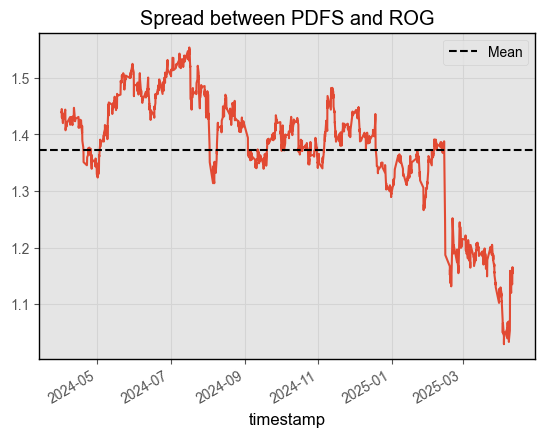

In [70]:
spread.plot(title=f"Spread between {asset1} and {asset2}")
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.legend()
plt.show()

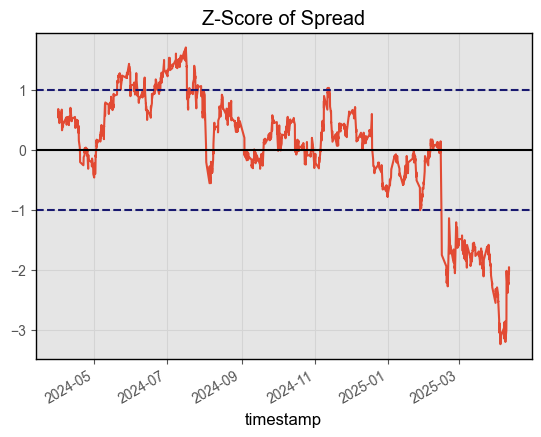

In [75]:
spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread - spread_mean) / spread_std

zscore.plot(title='Z-Score of Spread')
plt.axhline(0, color='black')
plt.axhline(1, color=pred_color_presentation('midnight-blue'), linestyle='--')
plt.axhline(-1, color=pred_color_presentation('midnight-blue'), linestyle='--')
plt.show()

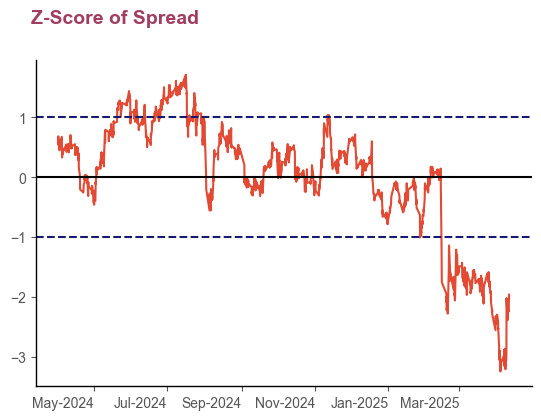

In [90]:
import matplotlib.dates as mdates

spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread - spread_mean) / spread_std

fig, ax = plt.subplots()
zscore.plot(ax=ax)

# Format x-axis as MMM-YYYY
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# Make x-axis labels horizontal
for label in ax.get_xticklabels():
    label.set_rotation(0)

# Add horizontal lines
ax.axhline(0, color=pred_color_presentation('black'))
ax.axhline(1, color=pred_color_presentation('midnight-blue'), linestyle='--')
ax.axhline(-1, color=pred_color_presentation('midnight-blue'), linestyle='--')

# Remove axis labels
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")

# Clean up background
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add annotation
plt.annotate(
    'Z-Score of Spread', 
    xy=(-0.01, 1.1), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

fig_name = f'zscore_spread.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

## Strategy

### Data Preparation

In [91]:
# Fetch data from database
query = f"""
SELECT a.timestamp, a.open, a.high, a.low, a.close, a.volume
FROM yahoo_data_min a
WHERE a.symbol = '{asset1}';
"""

ta_data1_df = db.fetch_data(query)

# Convert to proper datetime index
ta_data1_df = (
    ta_data1_df
    .set_index('timestamp')
    .pipe(lambda df: df.set_index(
        pd.to_datetime(df.index, utc=True)
        .tz_localize(None)  # Remove timezone for Backtrader
    ))
)

# Quality checks
assert ta_data1_df.index.tz is None, "Index still has timezone info"
assert not ta_data1_df.isnull().values.any(), "Data contains NaN values"

In [92]:
ta_data1_df.to_pickle('ta_data1_df.pkl')

In [93]:
# Fetch data from database
query = f"""
SELECT a.timestamp, a.open, a.high, a.low, a.close, a.volume
FROM yahoo_data_min a
WHERE a.symbol = '{asset2}';
"""

ta_data2_df = db.fetch_data(query)

# Convert to proper datetime index
ta_data2_df = (
    ta_data2_df
    .set_index('timestamp')
    .pipe(lambda df: df.set_index(
        pd.to_datetime(df.index, utc=True)
        .tz_localize(None)  # Remove timezone for Backtrader
    ))
)

# Quality checks
assert ta_data2_df.index.tz is None, "Index still has timezone info"
assert not ta_data2_df.isnull().values.any(), "Data contains NaN values"

In [94]:
ta_data2_df.to_pickle('ta_data2_df.pkl')

### Backtrader

In [95]:
class SpreadZScore(bt.Indicator):
    lines = ('spread', 'zscore',)
    params = (('window', 7),)
    
    def __init__(self):
        self.addminperiod(self.p.window)
        
    def next(self):
        price1 = np.array(self.data0.close.get(size=self.p.window))
        price2 = np.array(self.data1.close.get(size=self.p.window))
        
        X = sm.add_constant(price2)
        model = sm.OLS(price1, X).fit()
        beta = model.params[1]
        
        spread = price1[-1] - (beta * price2[-1])
        self.lines.spread[0] = spread
        
        if len(self.lines.spread) >= self.p.window:
            spread_window = np.array(self.lines.spread.get(size=self.p.window))
            mean = np.mean(spread_window)
            std = np.std(spread_window)
            self.lines.zscore[0] = (spread - mean) / std if std > 0 else 0

class PairsTradingStrategy(bt.Strategy):
    params = (
        ('window', 7),
        ('entry_threshold', 1.5),
        ('exit_threshold', 0.5),
        ('stop_loss', 2.5),
        ('take_profit', 2.0),
        ('order_pct', 0.95),
        ('printlog', False)
    )

    def __init__(self):
        self.spread_zscore = SpreadZScore(self.data0, self.data1, window=self.p.window)
        self.trade_count = 0
        self.in_position = False

    def next(self):
        if len(self.data0) < self.p.window or len(self.data1) < self.p.window:
            return
            
        zscore = self.spread_zscore.zscore[0]
        
        if not self.in_position:
            if zscore > self.p.entry_threshold:
                size0 = self.broker.getcash() * self.p.order_pct / self.data0.close[0]
                size1 = (size0 * self.data0.close[0]) / self.data1.close[0]
                self.sell(data=self.data0, size=size0)
                self.buy(data=self.data1, size=size1)
                self.in_position = True
                self.trade_direction = -1
                
            elif zscore < -self.p.entry_threshold:
                size0 = self.broker.getcash() * self.p.order_pct / self.data0.close[0]
                size1 = (size0 * self.data0.close[0]) / self.data1.close[0]
                self.buy(data=self.data0, size=size0)
                self.sell(data=self.data1, size=size1)
                self.in_position = True
                self.trade_direction = 1
                
        else:
            if ((self.trade_direction == 1 and zscore >= -self.p.exit_threshold) or
                (self.trade_direction == -1 and zscore <= self.p.exit_threshold) or
                abs(zscore) >= self.p.stop_loss):
                self.close(data=self.data0)
                self.close(data=self.data1)
                self.in_position = False

def prepare_data(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index(pd.to_datetime(df.index))
    return df[['open', 'high', 'low', 'close', 'volume']].ffill()

def optimize_strategy(symbol1, symbol2, df1, df2, initial_cash=100000):
    param_ranges = {
        'window': [5, 7, 14, 21],
        'entry_threshold': [1.0, 1.5, 2.0],
        'exit_threshold': [0.25, 0.5, 0.75],
        'order_pct': [0.8, 0.85, 0.9, 0.95]
    }
    
    results = []
    best_sharpe = -np.inf
    best_params = None
    
    for i, params in enumerate(product(*param_ranges.values())):
        window, entry_thresh, exit_thresh, order_pct = params
        
        cerebro = bt.Cerebro(stdstats=False)  # Disable default observers for optimization
        data1 = bt.feeds.PandasData(dataname=prepare_data(df1))
        data2 = bt.feeds.PandasData(dataname=prepare_data(df2))
        cerebro.adddata(data1, name=symbol1)
        cerebro.adddata(data2, name=symbol2)
        
        cerebro.addstrategy(
            PairsTradingStrategy,
            window=window,
            entry_threshold=entry_thresh,
            exit_threshold=exit_thresh,
            order_pct=order_pct,
            printlog=False
        )
        
        cerebro.broker.setcash(initial_cash)
        cerebro.broker.setcommission(0.001)
        
        # Add analyzers with proper configuration
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days)
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        
        try:
            strat = cerebro.run()[0]
            sharpe_analysis = strat.analyzers.sharpe.get_analysis()
            sharpe = sharpe_analysis['sharperatio'] if 'sharperatio' in sharpe_analysis else None
            dd_analysis = strat.analyzers.drawdown.get_analysis()
            
            if sharpe is None:
                print(f"Test {i+1}: No valid Sharpe ratio calculated - likely no trades")
                continue
                
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_params = params
                
            results.append({
                'window': window,
                'entry': entry_thresh,
                'exit': exit_thresh,
                'size': order_pct,
                'sharpe': sharpe,
                'drawdown': dd_analysis['max']['drawdown'],
                'final_value': cerebro.broker.getvalue(),
                'trades': strat.analyzers.trades.get_analysis().total.closed if hasattr(strat, 'analyzers') and hasattr(strat.analyzers, 'trades') else 0
            })
            
            print(f"Test {i+1}: Params {params} | Sharpe: {sharpe:.2f} | Trades: {results[-1]['trades']}")
            
        except Exception as e:
            print(f"Test {i+1} failed with params {params}: {str(e)}")
            continue

    if not results:
        raise ValueError("No valid backtests completed - check your data and parameters")
    
    results_df = pd.DataFrame(results).sort_values('sharpe', ascending=False)
    return results_df, best_params

def run_best_strategy(symbol1, symbol2, df1, df2, best_params, initial_cash=100000):
    cerebro = bt.Cerebro()
    data1 = bt.feeds.PandasData(dataname=prepare_data(df1))
    data2 = bt.feeds.PandasData(dataname=prepare_data(df2))
    cerebro.adddata(data1, name=symbol1)
    cerebro.adddata(data2, name=symbol2)
    
    cerebro.addstrategy(
        PairsTradingStrategy,
        window=best_params[0],
        entry_threshold=best_params[1],
        exit_threshold=best_params[2],
        order_pct=best_params[3],
        printlog=True
    )
    
    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(0.001)
    
    # Add analyzers with proper configuration
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    print('\n=== Running with Best Parameters ===')
    print(f"Window: {best_params[0]}")
    print(f"Entry Threshold: {best_params[1]}")
    print(f"Exit Threshold: {best_params[2]}")
    print(f"Order Percentage: {best_params[3]}")
    
    results = cerebro.run()
    strat = results[0]
    
    print('\n=== Final Results ===')
    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
    
    # Safe Sharpe ratio reporting
    sharpe_analysis = strat.analyzers.sharpe.get_analysis()
    sharpe = sharpe_analysis.get('sharperatio', None)
    print(f"Sharpe Ratio: {sharpe:.2f}" if sharpe is not None else "Sharpe Ratio: N/A (no trades)")
    
    # Safe drawdown reporting
    dd_analysis = strat.analyzers.drawdown.get_analysis()
    max_dd = dd_analysis.get('max', {}).get('drawdown', None)
    print(f"Max Drawdown: {max_dd:.2f}%" if max_dd is not None else "Max Drawdown: N/A")
    
    # Safe trade analysis
    try:
        trade_analysis = strat.analyzers.trades.get_analysis()
        total_trades = trade_analysis.total.closed
        won_trades = trade_analysis.won.total
        win_rate = (won_trades / total_trades * 100) if total_trades > 0 else 0
        
        print(f"\nTrade Analysis:")
        print(f"Total Trades: {total_trades}")
        print(f"Winning Trades: {won_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
    except Exception as e:
        print("\nTrade Analysis: Failed -", str(e))
        
    
    # Safe returns reporting
    try:
        returns_analysis = strat.analyzers.returns.get_analysis()
        rtot = returns_analysis.get('rtot', None)
        print(f"Total Return: {rtot:.2%}" if rtot is not None else "Total Return: N/A")

        # Plot and save the figure
        cerebro.plot(style='candlestick', volume=False)

        figs = cerebro.plot(style='candlestick', volume=False)
        for fig in figs:
            fig[0].set_size_inches(20, 10) 
            fig[0].savefig('cerebro_plot1.png', dpi=600)
            plt.show()
        print("Plot saved as cerebro_plot.png")

    except Exception as e:
        print("Returns Analysis: Failed -", str(e))


if __name__ == '__main__':
    # Load your data
    df1 = ta_data1_df
    df2 = ta_data2_df
    
    # Run optimization
    results_df, best_params = optimize_strategy(asset1, asset2, df1, df2)
    
    # Display top 5 results
    print("\nTop 5 Parameter Sets:")
    print(results_df.head(5))
    
    # Run with best parameters
    run_best_strategy(asset1, asset2, df1, df2, best_params)

Test 1: Params (5, 1.0, 0.25, 0.8) | Sharpe: -0.42 | Trades: 0
Test 2: Params (5, 1.0, 0.25, 0.85) | Sharpe: -0.42 | Trades: 0
Test 3: Params (5, 1.0, 0.25, 0.9) | Sharpe: -0.42 | Trades: 0
Test 4: Params (5, 1.0, 0.25, 0.95) | Sharpe: -0.41 | Trades: 0
Test 5: Params (5, 1.0, 0.5, 0.8) | Sharpe: -0.42 | Trades: 0
Test 6: Params (5, 1.0, 0.5, 0.85) | Sharpe: -0.42 | Trades: 0
Test 7: Params (5, 1.0, 0.5, 0.9) | Sharpe: -0.42 | Trades: 0
Test 8: Params (5, 1.0, 0.5, 0.95) | Sharpe: -0.45 | Trades: 0
Test 9: Params (5, 1.0, 0.75, 0.8) | Sharpe: -0.48 | Trades: 0
Test 10: Params (5, 1.0, 0.75, 0.85) | Sharpe: -0.48 | Trades: 0
Test 11: Params (5, 1.0, 0.75, 0.9) | Sharpe: -0.48 | Trades: 0
Test 12: Params (5, 1.0, 0.75, 0.95) | Sharpe: -0.52 | Trades: 0
Test 13: Params (5, 1.5, 0.25, 0.8) | Sharpe: -0.29 | Trades: 0
Test 14: Params (5, 1.5, 0.25, 0.85) | Sharpe: -0.29 | Trades: 0
Test 15: Params (5, 1.5, 0.25, 0.9) | Sharpe: -0.29 | Trades: 0
Test 16: Params (5, 1.5, 0.25, 0.95) | Sharpe:

<IPython.core.display.Javascript object>

Plot saved as cerebro_plot.png
